In [4]:
import numpy as np
import pandas as pd
import os, json
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import joblib
import warnings
import shap
warnings.filterwarnings("ignore")
np.random.seed(42)

In [5]:
# ---------- 1) Generate synthetic Telco-like dataset ----------
n = 7043
def gen_categorical(probs, choices):
    return np.random.choice(choices, size=n, p=probs)

gender = gen_categorical([0.49, 0.51], ["Female", "Male"])
senior = np.random.choice([0,1], size=n, p=[0.84, 0.16])
partner = gen_categorical([0.53, 0.47], ["No", "Yes"])
dependents = gen_categorical([0.7, 0.3], ["No", "Yes"])
tenure = np.random.randint(0, 73, size=n)
phone_service = gen_categorical([0.1, 0.9], ["No", "Yes"])
multiple_lines = []
for ps in phone_service:
    if ps == "No":
        multiple_lines.append("No phone service")
    else:
        multiple_lines.append(np.random.choice(["No", "Yes"], p=[0.7, 0.3]))
multiple_lines = np.array(multiple_lines)
internet = gen_categorical([0.3, 0.5, 0.2], ["No", "DSL", "Fiber optic"])
def yes_no_when_internet(p):
    arr=[]
    for it in internet:
        if it=="No":
            arr.append("No internet service")
        else:
            arr.append(np.random.choice(["No","Yes"], p=[1-p,p]))
    return np.array(arr)
online_security = yes_no_when_internet(0.2)
online_backup = yes_no_when_internet(0.25)
device_protection = yes_no_when_internet(0.2)
tech_support = yes_no_when_internet(0.15)
streaming_tv = yes_no_when_internet(0.3)
streaming_movies = yes_no_when_internet(0.3)
contract = gen_categorical([0.55, 0.25, 0.2], ["Month-to-month", "One year", "Two year"])
paperless_billing = gen_categorical([0.6,0.4], ["Yes","No"])
payment_method = gen_categorical([0.34,0.33,0.33], ["Electronic check","Mailed check","Bank transfer (automatic)"])
base_charge = np.where(internet=="Fiber optic", 80, np.where(internet=="DSL", 50, 20))
monthly_add = (online_security=="Yes")*5 + (online_backup=="Yes")*3 + (device_protection=="Yes")*4 + (tech_support=="Yes")*6 + (streaming_tv=="Yes")*4 + (streaming_movies=="Yes")*4 + (multiple_lines=="Yes")*3
monthly_charges = base_charge + monthly_add + np.round(np.random.normal(0,5,size=n),2)
total_charges = np.where(tenure==0, 0, np.round(monthly_charges * tenure + np.random.normal(0,20,size=n),2))
mask_missing = np.random.choice([0,1], size=n, p=[0.995,0.005]).astype(bool)
total_charges = total_charges.astype(object)
total_charges[mask_missing] = " "
churn_prob = ((contract=="Month-to-month")*0.25 + (payment_method=="Electronic check")*0.08 + (monthly_charges>70)*0.12 + (tenure<6)*0.1 + (senior==1)*0.02 - (contract=="Two year")*0.12 - (partner=="Yes")*0.03)
churn_prob = np.clip(churn_prob, 0.02, 0.7)
churn = np.array([np.random.choice(["No","Yes"], p=[1-p,p]) for p in churn_prob])
customerID = ["CUST"+str(100000+i) for i in range(n)]

df = pd.DataFrame({
    "customerID": customerID,
    "gender": gender,
    "SeniorCitizen": senior,
    "Partner": partner,
    "Dependents": dependents,
    "tenure": tenure,
    "PhoneService": phone_service,
    "MultipleLines": multiple_lines,
    "InternetService": internet,
    "OnlineSecurity": online_security,
    "OnlineBackup": online_backup,
    "DeviceProtection": device_protection,
    "TechSupport": tech_support,
    "StreamingTV": streaming_tv,
    "StreamingMovies": streaming_movies,
    "Contract": contract,
    "PaperlessBilling": paperless_billing,
    "PaymentMethod": payment_method,
    "MonthlyCharges": monthly_charges,
    "TotalCharges": total_charges,
    "Churn": churn
})
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")

In [6]:
df.head()
df.info()
df.describe()
df["Churn"].value_counts()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,count
Churn,
No,5700
Yes,1343


In [7]:
# ---------- 2) Preprocessing & split ----------
target = "Churn"
y = (df[target]=="Yes").astype(int)
id_col = "customerID"
features = [c for c in df.columns if c not in [id_col, target]]

num_features = ["tenure", "MonthlyCharges", "TotalCharges", "SeniorCitizen"]
cat_features = [c for c in features if c not in num_features]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])
preprocessor = ColumnTransformer(transformers=[
    ("num", numeric_transformer, num_features),
    ("cat", categorical_transformer, cat_features)
])

X_train, X_test, y_train, y_test = train_test_split(df[features], y, stratify=y, test_size=0.2, random_state=42)

In [8]:
# ---------- 3) Models & baseline ----------
clf_lr = Pipeline([("pre", preprocessor), ("clf", LogisticRegression(max_iter=1000, class_weight="balanced"))])
clf_rf = Pipeline([("pre", preprocessor), ("clf", RandomForestClassifier(n_estimators=200, random_state=42, class_weight="balanced"))])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
print("Baseline CV (Logistic Regression):")
print("  Accuracy:", cross_val_score(clf_lr, X_train, y_train, cv=cv, scoring="accuracy").mean())
print("  ROC AUC:", cross_val_score(clf_lr, X_train, y_train, cv=cv, scoring="roc_auc").mean())
print("Baseline CV (Random Forest):")
print("  Accuracy:", cross_val_score(clf_rf, X_train, y_train, cv=cv, scoring="accuracy").mean())
print("  ROC AUC:", cross_val_score(clf_rf, X_train, y_train, cv=cv, scoring="roc_auc").mean())

Baseline CV (Logistic Regression):
  Accuracy: 0.6056100778406968
  ROC AUC: 0.7463160325558518
Baseline CV (Random Forest):
  Accuracy: 0.7953495739171411
  ROC AUC: 0.7098498157341844


In [9]:
# ---------- 4) Fast randomized search to tune RF ----------
param_dist = {
    "clf__n_estimators": [100,200,300],
    "clf__max_depth": [None, 8, 12, 20],
    "clf__min_samples_split": [2,4,6],
    "clf__min_samples_leaf": [1,2,4]
}
search = RandomizedSearchCV(clf_rf, param_dist, n_iter=12, cv=cv, scoring="roc_auc", random_state=42, n_jobs=-1)
search.fit(X_train, y_train)
best_model = search.best_estimator_
print("Best params:", search.best_params_)
print("Best CV ROC AUC:", search.best_score_)

Best params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_depth': 8}
Best CV ROC AUC: 0.7374708992514976


In [10]:
# ---------- 5) Evaluate on test ----------
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:,1]
acc = accuracy_score(y_test, y_pred)
prec = precision_score(y_test, y_pred)
rec = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
auc = roc_auc_score(y_test, y_proba)
print("\nTest set metrics:")
print(f"Accuracy: {acc:.3f}, Precision: {prec:.3f}, Recall: {rec:.3f}, F1: {f1:.3f}, ROC AUC: {auc:.3f}")
print("\nClassification report:\n", classification_report(y_test, y_pred))



Test set metrics:
Accuracy: 0.625, Precision: 0.318, Recall: 0.844, F1: 0.462, ROC AUC: 0.750

Classification report:
               precision    recall  f1-score   support

           0       0.94      0.57      0.71      1140
           1       0.32      0.84      0.46       269

    accuracy                           0.63      1409
   macro avg       0.63      0.71      0.59      1409
weighted avg       0.82      0.63      0.66      1409



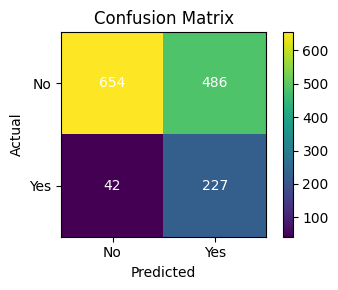

In [11]:
# Confusion matrix display
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(4,3))
plt.imshow(cm, interpolation='nearest')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.colorbar()
plt.xticks([0,1], ["No","Yes"])
plt.yticks([0,1], ["No","Yes"])
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i,j], horizontalalignment="center", verticalalignment="center", color="white")
plt.tight_layout()
plt.show()

In [12]:
# ---------- 6) Permutation importance ----------
# 1) Get the preprocessor and classifier objects from pipeline
pre = best_model.named_steps["pre"]            # ColumnTransformer
clf = best_model.named_steps["clf"]            # final estimator (RandomForestClassifier)

# 2) Transform X_test to the space the classifier actually receives
X_test_trans = pre.transform(X_test)           # numpy array (n_samples, n_transformed_features)
n_model_features = clf.n_features_in_          # number of features the classifier expects / used



In [13]:
# 3) Get feature names from the ColumnTransformer (robustly)
feature_names_full = None
try:
    # Preferred: modern sklearn
    feature_names_full = pre.get_feature_names_out()
except Exception:
    # Fallback: build names from numeric + OHE
    # numeric features were defined as num_features
    try:
        ohe = pre.named_transformers_["cat"].named_steps["onehot"]
    except Exception:
        # try another fallback in case the categorical transformer is not a Pipeline
        cat_tr = pre.named_transformers_.get("cat")
        if hasattr(cat_tr, "named_steps"):
            ohe = cat_tr.named_steps.get("onehot")
        else:
            ohe = cat_tr
    try:
        cat_ohe_names = ohe.get_feature_names_out(cat_features)
    except Exception:
        cat_ohe_names = ohe.get_feature_names(cat_features)
    feature_names_full = list(num_features) + list(cat_ohe_names)



In [14]:
# 4) Ensure length matches classifier input by slicing if necessary
if len(feature_names_full) < n_model_features:
    # sanity: this should not normally happen
    raise RuntimeError(f"ColumnTransformer produced {len(feature_names_full)} names but classifier expects {n_model_features}.")
feature_names = list(feature_names_full)[:n_model_features]



In [15]:
# 5) Run permutation importance on the classifier using preprocessed array
result = permutation_importance(
    clf,
    X_test_trans,   # preprocessed features (matches clf.n_features_in_)
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    scoring="roc_auc"   # ensure we're using the same metric
)



In [16]:
# 6) Build DataFrame and display
imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance_mean": result.importances_mean,
    "importance_std": result.importances_std
}).sort_values("importance_mean", ascending=False).reset_index(drop=True)

print("\nTop 10 important features:")
display(imp_df.head(10))




Top 10 important features:


,feature,importance_mean,importance_std
0,cat__Contract_Month-to-month,0.112023,0.013884
1,cat__Contract_Two year,0.021476,0.004884
2,cat__Contract_One year,0.017696,0.007570
3,num__MonthlyCharges,0.007270,0.006699
4,cat__PaymentMethod_Electronic check,0.004330,0.002398
5,num__TotalCharges,0.003837,0.001970
6,num__tenure,0.001695,0.002118
7,cat__DeviceProtection_No internet service,0.001337,0.000580
8,cat__PhoneService_No,0.000765,0.000629
9,cat__MultipleLines_No,0.000618,0.001493


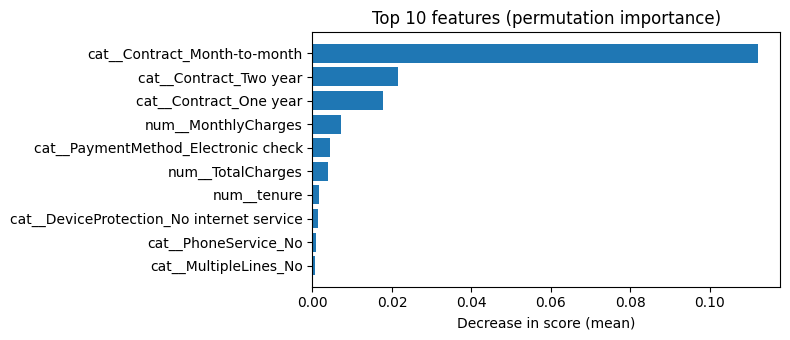

In [17]:
# 7) Plot top N
top_n = 10
plot_df = imp_df.head(top_n).sort_values("importance_mean")
plt.figure(figsize=(8, max(3, 0.35 * top_n)))
plt.barh(plot_df["feature"], plot_df["importance_mean"])
plt.title(f"Top {top_n} features (permutation importance)")
plt.xlabel("Decrease in score (mean)")
plt.tight_layout()
plt.show()

**Implementing SHAP**

In [18]:
# 1) Extract preprocessor & classifier
pre = best_model.named_steps["pre"]
clf = best_model.named_steps["clf"]

# 2) Transform X_train and X_test
X_train_trans = pre.transform(X_train)
X_test_trans  = pre.transform(X_test)

print("Train transformed:", X_train_trans.shape)
print("Test transformed :", X_test_trans.shape)


Train transformed: (5634, 44)
Test transformed : (1409, 44)


In [19]:
# 3) Build feature names
ohe = pre.named_transformers_["cat"].named_steps["onehot"]
ohe_names = list(ohe.get_feature_names_out(cat_features))
feature_names = list(num_features) + ohe_names

print("Number of feature names:", len(feature_names))

# Ensure feature_names matches transformed matrix size
if len(feature_names) != X_test_trans.shape[1]:
    print("Adjusting feature name list...")
    if len(feature_names) > X_test_trans.shape[1]:
        feature_names = feature_names[:X_test_trans.shape[1]]
    else:
        # add placeholders
        missing = X_test_trans.shape[1] - len(feature_names)
        feature_names += [f"Missing_{i}" for i in range(missing)]

print("Final feature name count:", len(feature_names))

Number of feature names: 44
Final feature name count: 44


In [20]:
# 4) Create SHAP Explainer (modern version)
explainer = shap.Explainer(clf.predict, X_train_trans)

# 5) Compute SHAP values for test data
sv = explainer(X_test_trans)
shap_values = sv.values

print("SHAP values shape:", shap_values.shape)

PermutationExplainer explainer: 1410it [05:37,  4.13it/s]

SHAP values shape: (1409, 44)


Generating SHAP summary plot...


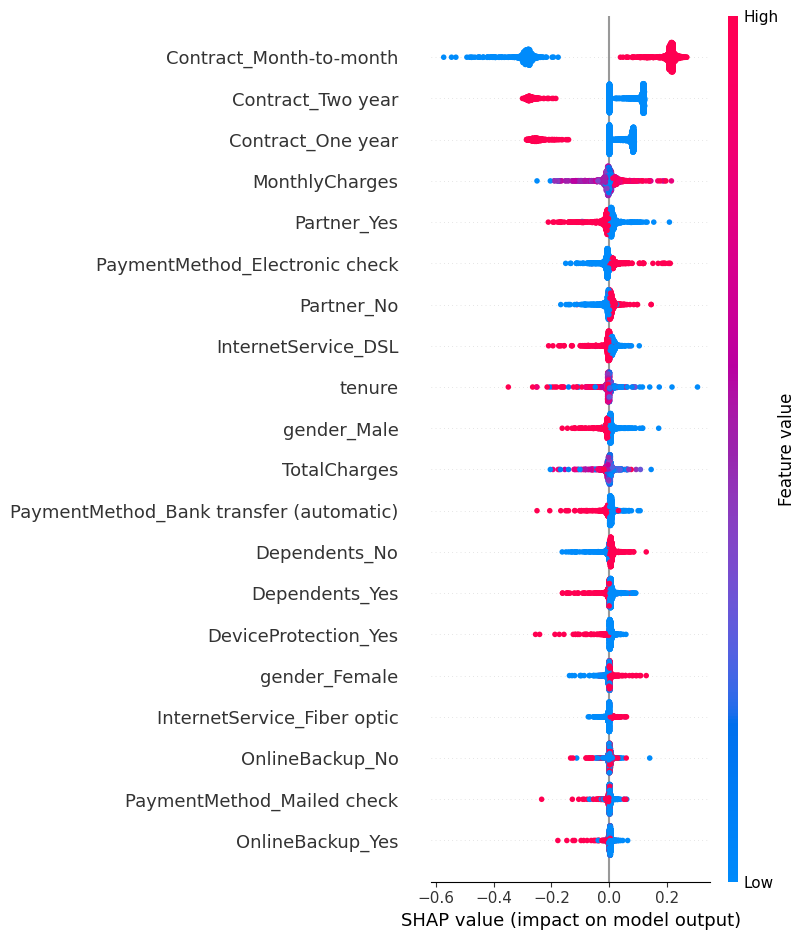

In [21]:
# 6) Summary plot (beeswarm)
print("Generating SHAP summary plot...")
shap.summary_plot(
    shap_values,
    X_test_trans,
    feature_names=feature_names
)

Generating SHAP bar plot...


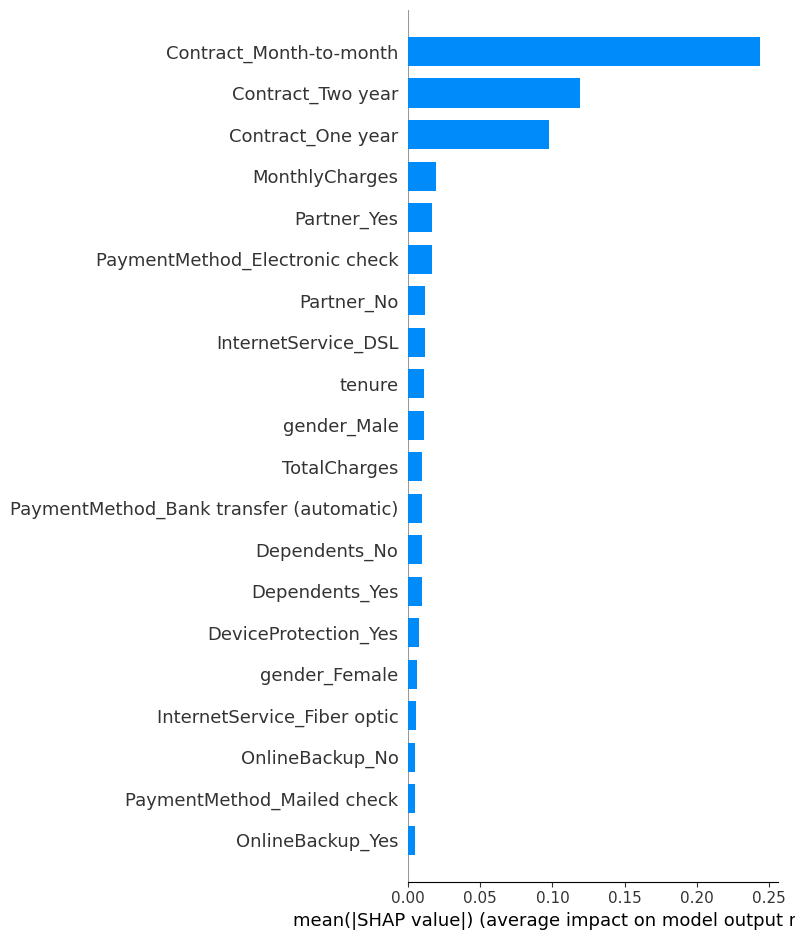

In [22]:
# 7) Bar plot (global importance)
print("Generating SHAP bar plot...")
shap.summary_plot(
    shap_values,
    X_test_trans,
    feature_names=feature_names,
    plot_type="bar"
)